In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import wrangle
import explore
import evaluate

from scipy import stats
from sklearn.linear_model import LinearRegression, TweedieRegressor, LassoLars
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PolynomialFeatures

# Shhhh
import warnings
warnings.filterwarnings("ignore")

### Planning
##### Goal:
- Project Objective: Identify an improved model for assessing value of single family properties for Zillow, using Zillow data about single family houses sold in 2017.
##### Deliverable:
- Deliver a model with above baseline accuracy.
##### Questions to Explore:
- Which features have the most weight on price?
- Does Area of the home, or number of Rooms play more of a role in house price?

------

### Data Acquisition and Data Preparations
Using our wrangel.py, we'll Acquire the data via cloud SQL and save a local copy as a .csv, any further need for data will load the local saved copy.

Outliers will be stripped, which will actually remove all null and missing values.

Histograms and Box Plots will be generated to visualise our data,

then it will be split into Train, Validate, and Test Dataframes.

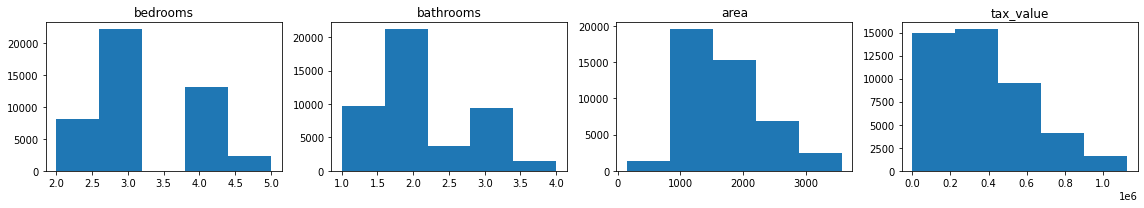

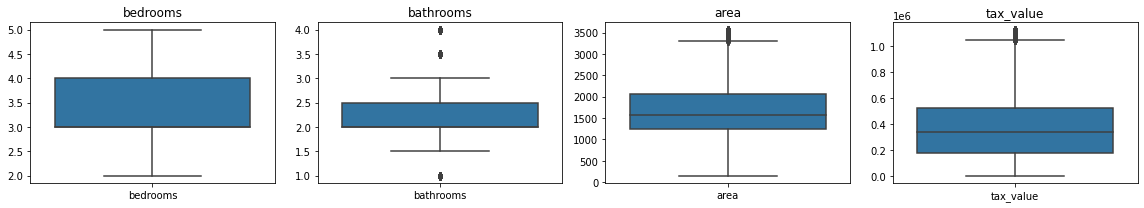

Train, Validate, and Test Shape:


((25550, 4), (10951, 4), (9126, 4))

In [2]:
train, validate, test = wrangle.wrangle_zillow_mvp()
print("Train, Validate, and Test Shape:")
train.shape, validate.shape, test.shape

In [3]:
train.dtypes

bedrooms     float64
bathrooms    float64
area         float64
tax_value    float64
dtype: object

The shape of the split looks good, as do our charts with more expected outliers. All Datatypes are what might be expected and are easily worked with as well.

-----

### Data Exploration
We'll begin visualising using the TRAIN dataframe. Comparing different features.

- first let's check the range of the columns.

In [4]:
explore.col_range(train)

             count           mean            std     min        25%       50%  \
bedrooms   25550.0       3.211624       0.793155     2.0       3.00       3.0   
bathrooms  25550.0       2.106810       0.728362     1.0       2.00       2.0   
area       25550.0    1704.667006     611.392984   152.0    1244.00    1572.0   
tax_value  25550.0  372885.466732  243793.023517  1000.0  174015.75  337600.5   

                 75%        max      range  
bedrooms        4.00        5.0        3.0  
bathrooms       2.50        4.0        3.0  
area         2070.75     3569.0     3417.0  
tax_value  523520.00  1123554.0  1122554.0  


Range of bedrooms and bathrooms are fairly expected, the range of the area though is larger than you'd expect, but that seems due to a very small house at 152sqft (it's not small enough to be an outlier though). The range of tax_value (our target) is a little daunting, with over 1,000,000 difference between lowest and highest, but we can do it.

- Let's look at some Categorical data vs. our goal now. [Using Train]

-=== bedrooms ===-
 
Value Counts:
-------------
3.0    12383
4.0     7262
2.0     4555
5.0     1350
Name: bedrooms, dtype: int64
 
Percent of Total:
-----------------
3.0    48.465753
4.0    28.422701
2.0    17.827789
5.0     5.283757
Name: bedrooms, dtype: float64
 
 >> P is less than Alpha.
 


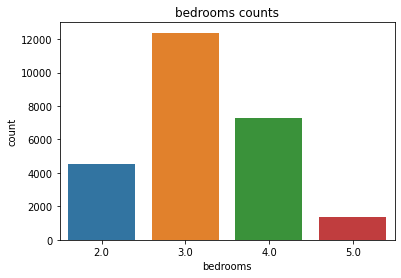

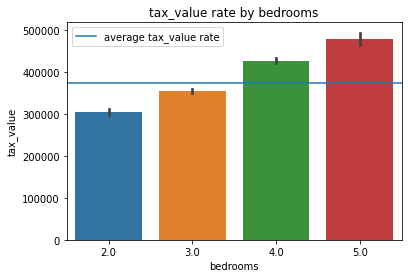

 
 
-=== bathrooms ===-
 
Value Counts:
-------------
2.0    11897
3.0     5302
1.0     4942
2.5     2068
4.0      595
1.5      487
3.5      259
Name: bathrooms, dtype: int64
 
Percent of Total:
-----------------
2.0    46.563601
3.0    20.751468
1.0    19.342466
2.5     8.093933
4.0     2.328767
1.5     1.906067
3.5     1.013699
Name: bathrooms, dtype: float64
 
 >> P is less than Alpha.
 


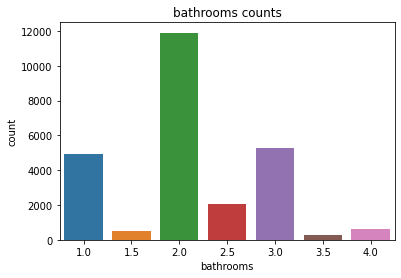

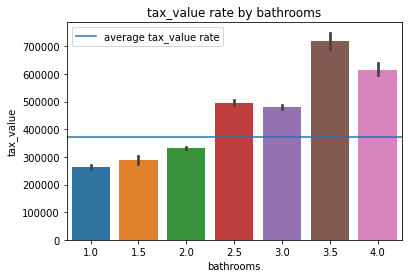

 
 
-=== tax_value ===-
 
Tax Value Average:
$ 372885.47
-------------


In [5]:
explore.explore_cat(train)

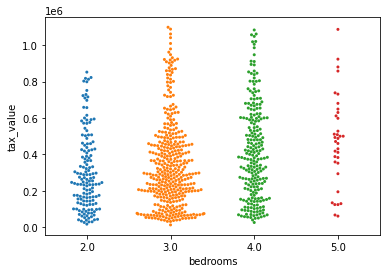

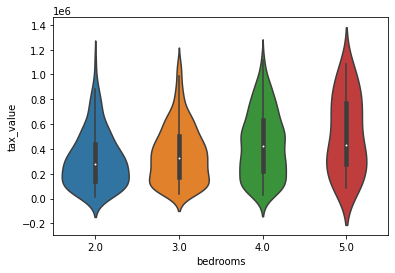

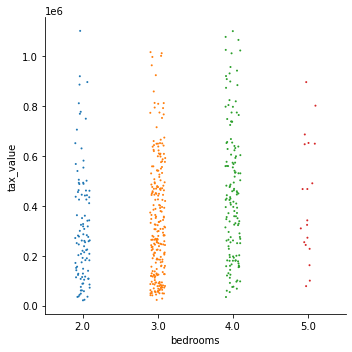

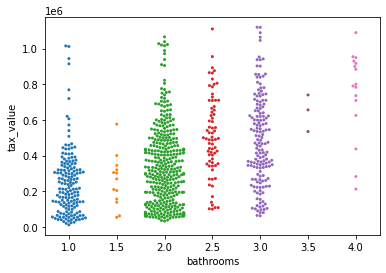

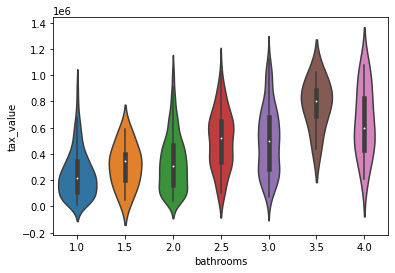

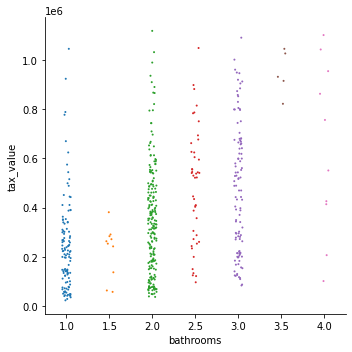

In [6]:
explore.plot_categorical_and_continuous_vars(train)

- And Variable Pairs (including correlations)

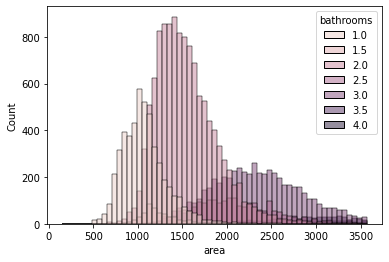

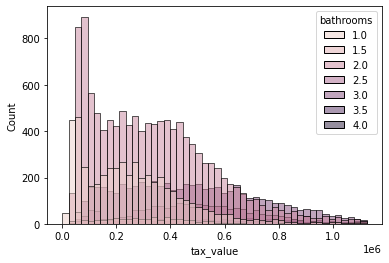

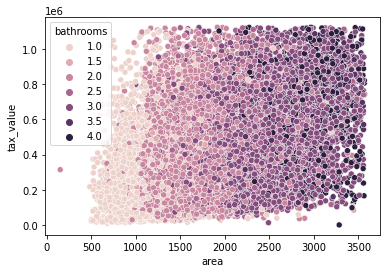

In [7]:
explore.explore_num(train)

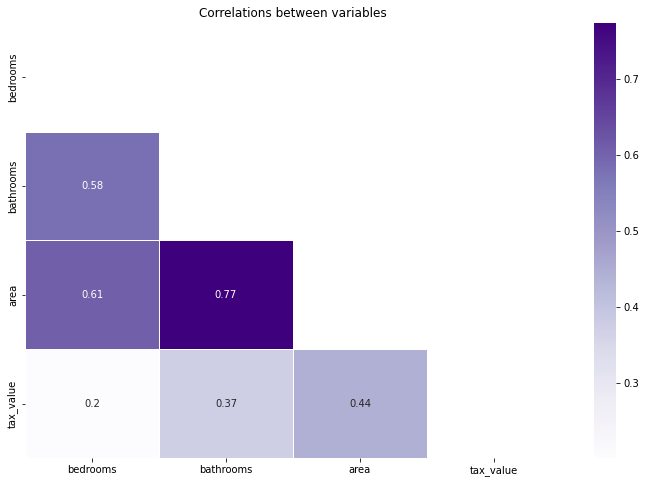

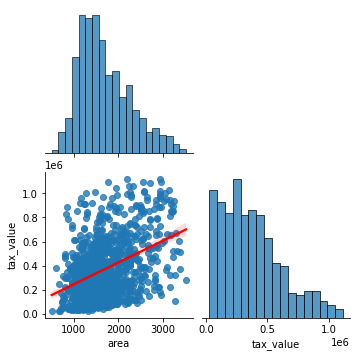

In [8]:
explore.plot_variable_pairs(train)

------

### Stats Testing

Looking at some of the charats above, we get an idea of how some of the data might correlate, so let's move onto testing the main hypothesis.

H0:
- There is no Correlation between [Bedrooms, Bathrooms, Area] and Tax Value.

Ha:
- There is a Correlation between [Bedrooms, Bathrooms, Area] and Tax Value.

Now, we saw above that generally Area, Bathroom, then Bedroom had the most correlation with Tax Value. Let's look into that again.

Area:
###### With the low starting point in area, let's try the lower of mean vs median.

In [9]:
explore.hypo_test_area(train)

We can Reject the Null Hypothesis.
This suggests there is more value in homes with above the median area than homes with median and below area.


- This is to be expected, a larger house is usually worth more.

Bathrooms:

In [10]:
explore.hypo_test_bathrooms(train)

Reject the Null Hypothesis.
This suggests there is more value in homes with above median number of bathrooms than homes with below the median number bathrooms.


- Again, More of something usually values at more.

Bedrooms:

In [11]:
explore.hypo_test_bedrooms(train)

Reject the Null Hypothesis.
This suggests there is more value in homes with above median number of bedrooms than homes with below median bedrooms.


- Yet again, More is more valuable.

Area vs. Bathroom:

In [35]:
explore.hypo_test_area_bath_compare(train)

Fail to reject the Null Hypothesis.
This suggests there is more value in homes with above median bathrooms than homes with above median area.

Fail to reject the Null Hypothesis.
This suggets there is more value in homes with below median bathrooms than homes with below median area.


- This is where it gets interesting, More bathrooms values higher than more square footage.
- On both counts, Bathrooms appear to be more prized than area.

Area vs. Bedroom:

In [13]:
explore.hypo_test_area_bed_compare(train)

Reject the Null Hypothesis.
This suggests there is more value in homes with above median area than homes with above median bedrooms.

Fail to reject the Null Hypothesis.
This suggets there is more value in homes with below median bedrooms than homes with below median area.


- Now here, More area is worth more than More bedrooms.
- But the lower half of bedrooms actually have more value than the lower half of area.
- Does that mean there is such a thing as too many rooms? and too few?

Bedroom vs. Bathroom:

In [14]:
explore.hypo_test_bed_bath_compare(train)

Fail to reject the Null Hypothesis.
This suggests there is more value in homes with above median bathrooms than homes with above median bedrooms.

Reject the Null Hypothesis.
This suggests there is more value in homes with below median bedrooms than homes with below median bathrooms.


- Here, given the other two tests, it's expected bathrooms would have more value since they beat area, and area beat bedrooms.
- But, it seems Bedrooms reign supreme for items wanted below the median, putting area at the bottom below bathrooms.

##### Testing some other stats:

Creating some new columns using ones we have, like Area per Bedroom/Bathroom.

In [15]:
train, validate, test = explore.create_new_columns(train, validate, test)
train.head()

,bedrooms,bathrooms,area,tax_value,area_by_bathroom,area_by_beds,bed_and_bath,rooms_and_area
16298,3.0,2.0,1631.0,94598.0,815.5,543.666667,5.0,0.003066
48457,4.0,2.0,1215.0,381640.0,607.5,303.750000,6.0,0.004938
52376,3.0,2.0,1671.0,208141.0,835.5,557.000000,5.0,0.002992
6335,2.0,2.0,1788.0,411393.0,894.0,894.000000,4.0,0.002237
8395,3.0,2.0,2605.0,561561.0,1302.5,868.333333,5.0,0.001919


###### Factoring in the tax_value might be useful as well. If time is given, we'll come back to that.

Let's check out correlations.

In [16]:
print("Area / # bathroom Correlation to Value:")
explore.correlation(train,"area_by_bathroom")

Area / # bathroom Correlation to Value:
Correlation: 0.07
P: 1.2694905890428193e-27


In [17]:
print("Area / # bedroom Correlation to Value:")
explore.correlation(train,"area_by_beds")

Area / # bedroom Correlation to Value:
Correlation: 0.34
P: 0.0


In [18]:
print("Area / # rooms Correlation to Value:")
explore.correlation(train,"rooms_and_area")

Area / # rooms Correlation to Value:
Correlation: -0.29
P: 0.0


In [19]:
print("Bedrooms + Bathrooms Correlation to Value:")
explore.correlation(train,"bed_and_bath")

Bedrooms + Bathrooms Correlation to Value:
Correlation: 0.32
P: 0.0


They're about on par if not less than the default : Area, Bedrooms, Bathrooms

In [20]:
print("Area Correlation to Value:")
explore.correlation(train,"area")

Area Correlation to Value:
Correlation: 0.41
P: 0.0


In [21]:
print("Bathroom Correlation to Value:")
explore.correlation(train,"bathrooms")

Bathroom Correlation to Value:
Correlation: 0.37
P: 0.0


In [22]:
print("Bedroom Correlation to Value:")
explore.correlation(train,"bedrooms")

Bedroom Correlation to Value:
Correlation: 0.2
P: 1.5035204041749308e-232


Honestly, my thoughts are Area, Bathroom, and Bedroom are the best for building models. I enclude Bedrooms because they appear to have the biggest affect on the lower end of the spectrum, so it might help balance the models.

------

### Feature Engineering

Let's create X,y dataframes, and verify my conclusions with some SKLearn calculations:

In [23]:
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.df_split(train,validate,test)
X_train.shape, y_train.shape

((25550, 7), (25550, 1))

Using LinearRegression:

In [24]:
explore.select_best(X_train, y_train, 2)

KBest:
['bathrooms', 'area']
None
 
RFE:
['bedrooms', 'bed_and_bath']
None
 
SFS:
['bedrooms', 'area']
None


Using LassoLars:

In [25]:
explore.select_best(X_train, y_train, 2, model=LassoLars(alpha=1.0))

KBest:
['bathrooms', 'area']
None
 
RFE:
['bathrooms', 'rooms_and_area']
None
 
SFS:
['bedrooms', 'area']
None


Using TweedieRegressor:

In [26]:
explore.select_best(X_train, y_train, 2, model = TweedieRegressor(power=1, alpha=0))

KBest:
['bathrooms', 'area']
None
 
RFE:
['bed_and_bath', 'rooms_and_area']
None
 
SFS:
['bedrooms', 'bathrooms']
None


So there's a couple wild cards, Bed and Bath, as well as Rooms and Area. So let's keep those two on the models.

We'll drop area_by_bathroom, and area_by_beds, then resplit into X,y.

In [27]:
train = train.drop(columns=["area_by_bathroom", "area_by_beds"])
validate = validate.drop(columns=["area_by_bathroom", "area_by_beds"])
test = test.drop(columns=["area_by_bathroom", "area_by_beds"])
train.head()

,bedrooms,bathrooms,area,tax_value,bed_and_bath,rooms_and_area
16298,3.0,2.0,1631.0,94598.0,5.0,0.003066
48457,4.0,2.0,1215.0,381640.0,6.0,0.004938
52376,3.0,2.0,1671.0,208141.0,5.0,0.002992
6335,2.0,2.0,1788.0,411393.0,4.0,0.002237
8395,3.0,2.0,2605.0,561561.0,5.0,0.001919


There, now we've got the features we want to keep. Now to fix our X,y.

In [28]:
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.df_split(train, validate, test)
X_train.shape, y_train.shape, X_validate.shape, y_validate.shape, X_test.shape, y_test.shape

((25550, 5), (25550, 1), (10951, 5), (10951, 1), (9126, 5), (9126, 1))

Shape looks good; Now we're all set for modeling

---------

### Modeling

Now to try out our selected features on some actual models.

Let's check the RMSE and r^2 for several different models, a metric df will be created will all the stats for the different models. The baseline and predictions will also be added to y_train and y_validate. 

In [29]:
evaluate.model_metrics_all(X_train, y_train, X_validate, y_validate)

RMSE Mean is lower so we'll use that : 243788.25256933476
y shape:
(10951, 4)
----------
out of sample shape:
(10951,)
y shape:
(10951, 5)
----------
out of sample shape:
(10951,)
y shape:
(10951, 6)
----------
out of sample shape:
(10951,)
y shape:
(10951, 7)
----------
out of sample shape:
(10951,)


,model,rmse,r^2
0,baseline_mean,5.943271e+10,0.000000
1,linear_regression,2.205395e+05,0.203221
2,lasso_lars,2.205523e+05,0.203114
3,glm,2.470655e+05,0.000000
4,polynomial_regression_deg2,2.205430e+05,0.203182


In [30]:
y_train, y_validate = evaluate.rmse_in_out(X_train, y_train, X_validate, y_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  216856.18050469778 
Validation/Out-of-Sample:  220539.4747717098
-----
RMSE for Lasso + Lars
Training/In-Sample:  216853.2152719072 
Validation/Out-of-Sample:  220542.06464866508
-----
RMSE for GLM (Generalised Linar Model) using Tweedie, power=1 & alpha=0
Training/In-Sample:  243788.25256933476 
Validation/Out-of-Sample:  247065.52052137486


In [31]:
y_train.head()

,tax_value,baseline_mean,baseline_median,linear_regression,lasso_lars,glm,polynomial_regression_deg2,pred_lm,pred_lars,pred_glm
16298,94598.0,372885.466732,337600.5,363130.135509,364147.568678,372885.466732,362824.288035,363130.135509,363172.519783,372885.466732
48457,381640.0,372885.466732,337600.5,255134.283300,255506.284961,372885.466732,256799.085263,255134.283300,256458.874657,372885.466732
52376,208141.0,372885.466732,337600.5,370073.889697,371069.762899,372885.466732,369768.586688,370073.889697,370111.001481,372885.466732
6335,411393.0,372885.466732,337600.5,431426.266184,428392.317212,372885.466732,429561.551008,431426.266184,429253.857904,372885.466732
8395,561561.0,372885.466732,337600.5,538510.329218,533181.130532,372885.466732,538308.931051,538510.329218,536959.509862,372885.466732


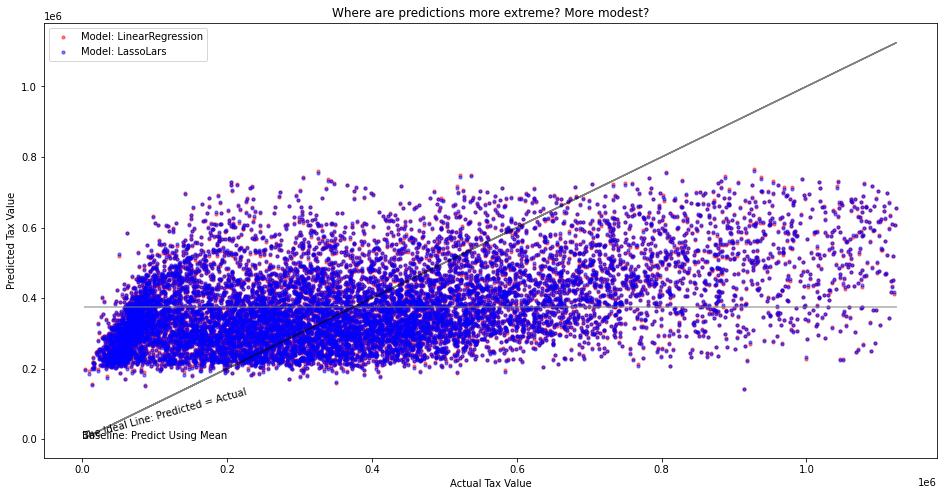

In [32]:
evaluate.plot_pred(y_validate)

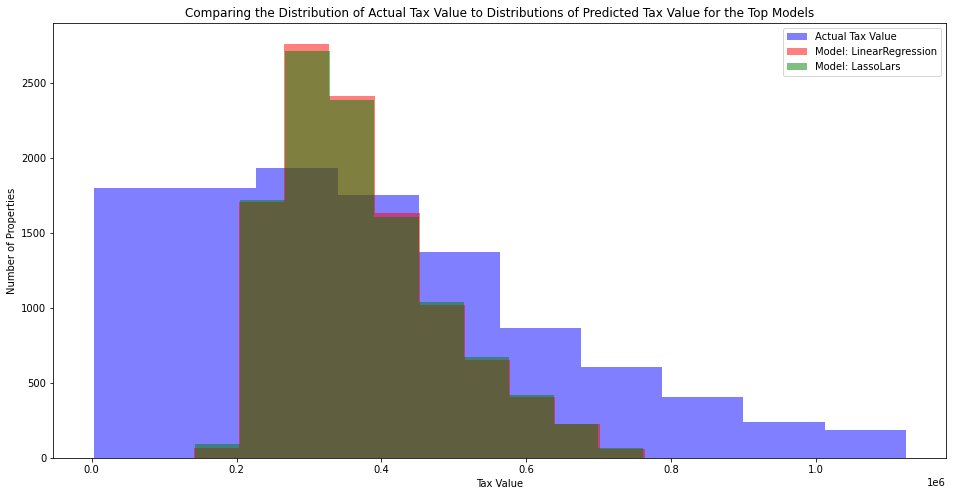

In [33]:
evaluate.plot_pred_hist(y_validate)

So none of them are great, but Linear Regression and LassoLars are my top two picks, looking at the above charts, I like LassoLars just a smidge more due to having a tad more distribution within the blue actual tax_value area.

##### Final Model:

Fitting the LassoLars to X,y train dataframe, and evaluating on X,y test.

In [34]:
evaluate.final_model(X_train, y_train, X_test, y_test)

RMSE for OLS Model using Lasso + Lars
Out-of-Sample Performance:  214818.064501288


### Conclusions

There is a lot more that contributes to house value than just squarefootage, number of bathrooms and number of bedrooms. Location is very important, as is how much property the house sits on. With more time I'd like to start with Location and Property Size, then branch out further from there.

Otherwise, Lasso + Lars with a 3.8 Alpha is slightly better than Normalised Linear Regression with the basic values we're working with.